In [1]:
# !pip install sentence-transformers

## Gerador de embeddings escolhido: CLIP (Contrastive Language-Image Pretraining)

O modelo CLIP (Contrastive Language-Image Pretraining) foi o escolhido para gerar os embeddings dos produtos, pois ele é capaz de combinar tanto a imagem quanto a descrição textual de cada produto em um único espaço latente. É de nosso interesse que o embedding da imagem e o da descrição fiquem próximos, facilitando a comparação entre diferentes representações do mesmo produto.

Fonte interessante: <https://medium.com/crayon-ai/search-engine-for-clothes-using-clip-2f13d14c6b68>

In [2]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image, ImageFile
import requests
import torch

# We use the original clip-ViT-B-32 for encoding images
img_model = SentenceTransformer('clip-ViT-B-32')

# Our text embedding model is aligned to the img_model and maps 50+
# languages to the same vector space
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transfo

In [3]:
# gerando embeddings

# - passa por todas as imagens e gera o embedding
# - salva o resultado em um df, de colunas nome_arquivo, emb_0, emb_1 ...
# - salva o df em um arquivo parquet

import pandas as pd
import os
import numpy as np

pasta = "clothes_images"
# Criando lista com as image_paths da pasta
image_paths = [os.path.join(pasta, path).replace('\\','/') for path in os.listdir(pasta)]

# Criando um df com os nomes das imagens
df = pd.DataFrame(image_paths, columns=["image_path"])
df["file_name"] = df["image_path"].apply(lambda x: x.split("/")[-1].split(".")[0])

In [4]:
# Criando ID a partir de file_name pegando tudo antes do segundo _
df["id"] = df["file_name"].apply(lambda x: x.split("_")[:2])

# Transformando a coluna id em string com os dois elementos separados por _
df["id"] = df["id"].apply(lambda x: "_".join(x))

In [5]:
df.shape

(64, 3)

In [6]:
df.head()

,image_path,file_name,id
0,clothes_images/313278_02851_2-BLUSA-GOLA-MANGA...,313278_02851_2-BLUSA-GOLA-MANGAS,313278_02851
1,clothes_images/317431_0700_2-CROPPED-MANGA-LON...,317431_0700_2-CROPPED-MANGA-LONGA-ADIDAS-ESTAM...,317431_0700
2,clothes_images/323253_0013_1-CALCA-BICOLOR-ALF...,323253_0013_1-CALCA-BICOLOR-ALFAIATARIA,323253_0013
3,clothes_images/323253_07032_1-CALCA-BICOLOR-AL...,323253_07032_1-CALCA-BICOLOR-ALFAIATARIA,323253_07032
4,clothes_images/324277_0012_1-CALCA-SARJA-CARGO...,324277_0012_1-CALCA-SARJA-CARGO-COM-CINTO,324277_0012


In [7]:
from tqdm import tqdm

def get_img_embeddings(df, path_column, img_model):
  """
  Função que recebe um dataframe, a coluna que contém o caminho das imagens e o modelo de imagem
  Usa o modelo para conseguir os embeddings da imagem e salva no df
  """
  emb_columns = [f"emb_img_{i}" for i in range(512)]
  
  # Now we load and encode the images
  def load_image(url_or_path):
      if url_or_path.startswith("http://") or url_or_path.startswith("https://"):
          return Image.open(requests.get(url_or_path, stream=True).raw)
      else:
          return Image.open(url_or_path)

  file_names = df[path_column].values
  images = [load_image(img) for img in file_names]
  img_embeddings = img_model.encode(images)

  # Colocando os embeddings no df
  emb_dict = {}
  for i, emb in enumerate(img_embeddings):
    emb_id = df.iloc[i]["id"]
    emb_dict[emb_id] = emb

  df_embs = pd.DataFrame(emb_dict).T

  df_embs.columns = emb_columns
  df_embs["id"] = df_embs.index

  return df_embs.reset_index(drop=True)[["id"] + emb_columns]

def get_text_embeddings(df, text_model):
  """
  Função que recebe um dataframe e o modelo de texto
  Usa o modelo para conseguir os embeddings da coluna desc_produto e salva no df
  """

  emb_columns = [f"emb_text_{i}" for i in range(512)]
  
  # Now we encode the text
  text_embeddings = text_model.encode(df["desc_produto"].values)

  # Colocando os embeddings no df
  emb_dict = {}
  for i, emb in enumerate(text_embeddings):
    emb_id = df.iloc[i]["id"]
    emb_dict[emb_id] = emb

  df_embs = pd.DataFrame(emb_dict).T

  df_embs.columns = emb_columns

  df_embs["id"] = df_embs.index

  return df_embs.reset_index(drop=True)[["id"] + emb_columns]


In [8]:
df.loc[df['id'].duplicated()]

,image_path,file_name,id


In [9]:
df_img_embs = get_img_embeddings(df, "image_path", img_model)

In [10]:
df_img_embs.shape

(64, 513)

In [11]:
df_img_embs.to_parquet("datasets/img_embeddings.parquet")
df_img_embs.head(1)

,id,emb_img_0,emb_img_1,emb_img_2,emb_img_3,emb_img_4,emb_img_5,emb_img_6,emb_img_7,emb_img_8,...,emb_img_502,emb_img_503,emb_img_504,emb_img_505,emb_img_506,emb_img_507,emb_img_508,emb_img_509,emb_img_510,emb_img_511
0,313278_02851,0.270649,-0.068943,-0.142831,0.160612,-0.448108,0.355952,-0.259336,0.197335,0.52908,...,-0.134417,-0.11291,0.619426,-0.226216,-0.368055,0.21295,0.231464,0.116424,-0.064459,0.813807


### Extraindo descrições dos produtos
As imagens foram nomeadas de forma que contém o ID do produto e sua respectiva descrição. Vamos extrair essas descrições para gerar embeddings dos textos também.

In [12]:
# Iterando nos filedf['file_name'] e pegando tudo após o primeiro -
df['desc_produto'] = df['file_name'].apply(lambda x: x.split("-")[1:]).apply(lambda x: " ".join(x).capitalize())

In [13]:
df.sample(5)

,image_path,file_name,id,desc_produto
34,clothes_images/330156_04530_1-VESTIDO-CURTO-CO...,330156_04530_1-VESTIDO-CURTO-CORSELET,330156_04530,Vestido curto corselet
32,clothes_images/330152_07415_1-MACACAO-PREGAS-P...,330152_07415_1-MACACAO-PREGAS-PANTALONA,330152_07415,Macacao pregas pantalona
52,clothes_images/331733_0142_2-SAIA-JEANS-MIDI-G...,331733_0142_2-SAIA-JEANS-MIDI-GODE,331733_0142,Saia jeans midi gode
38,clothes_images/330157_07414_2-VESTIDO-CURTO-MA...,330157_07414_2-VESTIDO-CURTO-MANGAS-BUFANTES,330157_07414,Vestido curto mangas bufantes
6,clothes_images/325155_0700_2-CAMISA-ADIDAS-SOL...,325155_0700_2-CAMISA-ADIDAS-SOLAR-KALEIDOSCOPE...,325155_0700,Camisa adidas solar kaleidoscope rosa


In [14]:
# Extraindo embeddings de texto
df_text_embs = get_text_embeddings(df, text_model)

In [15]:
df_text_embs.to_parquet("datasets/text_embeddings.parquet")

## Testando semelhança entre as descrições

In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Extraímos os embeddings de imagem e texto dos respectivos dataframes
img_embeddings = df_img_embs.iloc[:, 1:].values  # Todas as colunas exceto 'id'
text_embeddings = df_text_embs.iloc[:, 1:].values  # Todas as colunas exceto 'id'

# Calculamos a similaridade de cosseno entre todos os pares de vetores de texto e imagem
# cosine_similarity calcula a similaridade entre cada vetor de um conjunto e cada vetor de outro conjunto
cos_sim = cosine_similarity(text_embeddings, img_embeddings)

# Para cada texto, encontramos a imagem mais similar com base na similaridade de cosseno
for i, text in enumerate(df_text_embs['id']):  # Itera sobre os IDs dos textos
    scores = cos_sim[i]  # Similaridades do texto i com todas as imagens
    max_img_idx = np.argmax(scores)  # Índice da imagem com maior similaridade
    
    print("Texto ID:", text, "\nTexto:", df.iloc[i]['desc_produto'])
    print("Maior Similaridade:", scores[max_img_idx])
    print("Imagem ID:", df_img_embs.iloc[max_img_idx]["id"], df.iloc[max_img_idx]['desc_produto'])
    print(" --------------------- \n")


Texto ID: 313278_02851 
Texto: Blusa gola mangas
Maior Similaridade: 0.24865462
Imagem ID: 330102_05052 Camisa bolso longa
 --------------------- 

Texto ID: 317431_0700 
Texto: Cropped manga longa adidas estampado sunny day vivid red
Maior Similaridade: 0.27424854
Imagem ID: 330102_07415 Camisa bolso longa
 --------------------- 

Texto ID: 323253_0013 
Texto: Calca bicolor alfaiataria
Maior Similaridade: 0.25765365
Imagem ID: 323253_0013 Calca bicolor alfaiataria
 --------------------- 

Texto ID: 323253_07032 
Texto: Calca bicolor alfaiataria
Maior Similaridade: 0.25765365
Imagem ID: 323253_0013 Calca bicolor alfaiataria
 --------------------- 

Texto ID: 324277_0012 
Texto: Calca sarja cargo com cinto
Maior Similaridade: 0.23450316
Imagem ID: 331714_0142 Calca jeans wide recorte
 --------------------- 

Texto ID: 324786_0105 
Texto: Calca jeans ampla pregas baixa
Maior Similaridade: 0.29674137
Imagem ID: 331714_0142 Calca jeans wide recorte
 --------------------- 

Texto ID: 325155

In [17]:
# Função para plotar a imagem a partir do caminho
from matplotlib import pyplot as plt
from PIL import Image

def plot_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

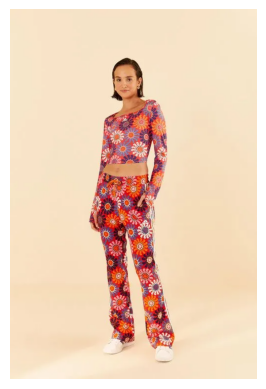

Texto ID: 313278_02851 
Texto: Blusa gola mangas
Similaridade: 0.21183306
 --------------------- 

Texto ID: 317431_0700 
Texto: Cropped manga longa adidas estampado sunny day vivid red
Similaridade: 0.22633804
 --------------------- 

Texto ID: 323253_0013 
Texto: Calca bicolor alfaiataria
Similaridade: 0.22514142
 --------------------- 

Texto ID: 323253_07032 
Texto: Calca bicolor alfaiataria
Similaridade: 0.22514144
 --------------------- 

Texto ID: 324277_0012 
Texto: Calca sarja cargo com cinto
Similaridade: 0.2165439
 --------------------- 

Texto ID: 324786_0105 
Texto: Calca jeans ampla pregas baixa
Similaridade: 0.22825888
 --------------------- 

Texto ID: 325155_0700 
Texto: Camisa adidas solar kaleidoscope rosa
Similaridade: 0.25326365
 --------------------- 

Texto ID: 325496_46188 
Texto: Vestido crochet estampado cobra yawanawa
Similaridade: 0.2679019
 --------------------- 

Texto ID: 325755_46189 
Texto: Calca estampada cobra maxi
Similaridade: 0.20910332
 ----------

In [18]:
# Printando a similaridade de uma imagem com todos os textos
# Escolhendo uma imagem aleatória
img_idx = 1

# Calculando a similaridade de cosseno entre a imagem escolhida e todos os textos
scores = cos_sim[:, img_idx]

# Plotando a imagem e printando cada texto com a respectiva similaridade
image_path = df.iloc[img_idx]['image_path']
plot_image(image_path)

for i, text in enumerate(df_text_embs['id']):
    print("Texto ID:", text, "\nTexto:", df.iloc[i]['desc_produto'])
    print("Similaridade:", scores[i])
    print(" --------------------- \n")




#### Parece que as descrições registradas não estão boas o suficiente.

## Testando com descrições manuais

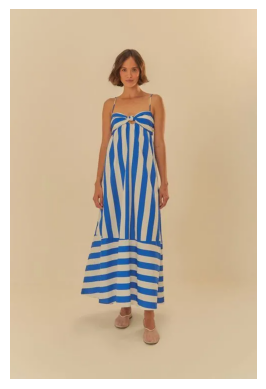

In [31]:
# Escolhendo uma imagem aleatória
img_idx = 41

image_path = df.iloc[img_idx]['image_path']
plot_image(image_path)

In [32]:
# Verificando qual é o texto mais similar a essa imagem
scores = cos_sim[:, img_idx]

max_text_idx = np.argmax(scores)
print("Imagem ID:", df_img_embs.iloc[img_idx]["id"], df.iloc[img_idx]['desc_produto'])
print("Maior Similaridade:", scores[max_text_idx])
print("Texto ID:", df_text_embs.iloc[max_text_idx]["id"], df.iloc[max_text_idx]['desc_produto'])
print(" --------------------- \n")


Imagem ID: 330163_05052 Vestido alcinhas listras
Maior Similaridade: 0.2629599
Texto ID: 332043_48315 Vestido curto estampado milani coqueiros
 --------------------- 



Texto Manual: White dress with blue stripes
Maior Similaridade: 0.30910408
Imagem ID: 330163_05052 Vestido alcinhas listras
 --------------------- 



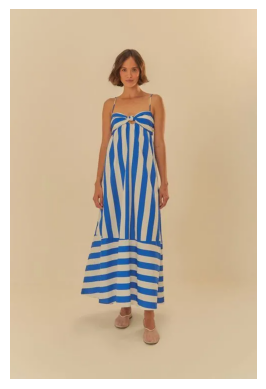

In [33]:
desc_manual = "White dress with blue stripes"

# embedding do texto
desc_manual_emb = text_model.encode(desc_manual)

# Calculando a similaridade de cosseno entre o texto manual e todas as imagens
cos_sim_manual = cosine_similarity([desc_manual_emb], img_embeddings)

scores = cos_sim_manual[0]  # Similaridades do texto manual com todas as imagens

# Mostrando a imagem com maior similaridade com o texto manual
max_img_idx = np.argmax(scores)
print("Texto Manual:", desc_manual)
print("Maior Similaridade:", scores[max_img_idx])
print("Imagem ID:", df_img_embs.iloc[max_img_idx]["id"], df.iloc[max_img_idx]['desc_produto'])
print(" --------------------- \n")

plot_image(df.iloc[max_img_idx]['image_path'])

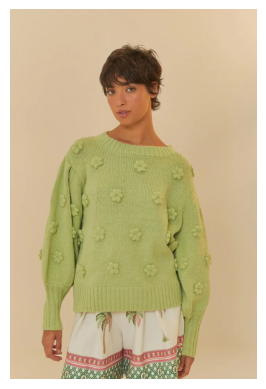

In [22]:
# Escolhendo uma imagem aleatória
img_idx = 15

image_path = df.iloc[img_idx]['image_path']
plot_image(image_path)

In [23]:
# Verificando qual é o texto mais similar a essa imagem
scores = cos_sim[:, img_idx]

max_text_idx = np.argmax(scores)
print("Imagem ID:", df_img_embs.iloc[img_idx]["id"], df.iloc[img_idx]['desc_produto'])
print("Maior Similaridade:", scores[max_text_idx])
print("Texto ID:", df_text_embs.iloc[max_text_idx]["id"], df.iloc[max_text_idx]['desc_produto'])
print(" --------------------- \n")


Imagem ID: 329688_07421 Pull tricot artesanal floresv
Maior Similaridade: 0.30291384
Texto ID: 329688_07421 Pull tricot artesanal floresv
 --------------------- 



Texto Manual: Agasalho de tricot verde com flores bordadas
Maior Similaridade: 0.33552533
Imagem ID: 329688_07421 Pull tricot artesanal floresv
 --------------------- 



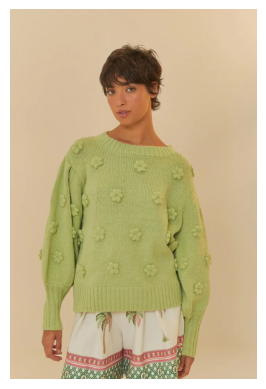

In [24]:
desc_manual = "Agasalho de tricot verde com flores bordadas"

# embedding do texto
desc_manual_emb = text_model.encode(desc_manual)

# Calculando a similaridade de cosseno entre o texto manual e todas as imagens
cos_sim_manual = cosine_similarity([desc_manual_emb], img_embeddings)

scores = cos_sim_manual[0]  # Similaridades do texto manual com todas as imagens

# Mostrando a imagem com maior similaridade com o texto manual
max_img_idx = np.argmax(scores)
print("Texto Manual:", desc_manual)
print("Maior Similaridade:", scores[max_img_idx])
print("Imagem ID:", df_img_embs.iloc[max_img_idx]["id"], df.iloc[max_img_idx]['desc_produto'])
print(" --------------------- \n")

plot_image(df.iloc[max_img_idx]['image_path'])

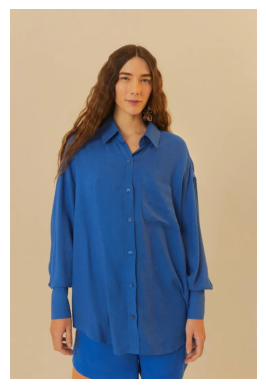

In [25]:
# Escolhendo uma imagem aleatória
img_idx = 24

image_path = df.iloc[img_idx]['image_path']
plot_image(image_path)

In [26]:
# Verificando qual é o texto mais similar a essa imagem
scores = cos_sim[:, img_idx]

max_text_idx = np.argmax(scores)
print("Imagem ID:", df_img_embs.iloc[img_idx]["id"], df.iloc[img_idx]['desc_produto'])
print("Maior Similaridade:", scores[max_text_idx])
print("Texto ID:", df_text_embs.iloc[max_text_idx]["id"], df.iloc[max_text_idx]['desc_produto'])
print(" --------------------- \n")


Imagem ID: 330102_05052 Camisa bolso longa
Maior Similaridade: 0.2781334
Texto ID: 330102_02362 Camisa bolso longa
 --------------------- 



Texto Manual: Camisa azul com mangas longas e bolso frontal
Maior Similaridade: 0.3360673
Imagem ID: 330102_05052 Camisa bolso longa
 --------------------- 



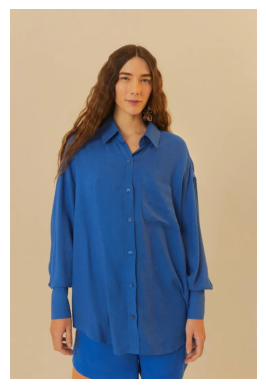

In [27]:
desc_manual = "Camisa azul com mangas longas e bolso frontal"

# embedding do texto
desc_manual_emb = text_model.encode(desc_manual)

# Calculando a similaridade de cosseno entre o texto manual e todas as imagens
cos_sim_manual = cosine_similarity([desc_manual_emb], img_embeddings)

scores = cos_sim_manual[0]  # Similaridades do texto manual com todas as imagens

# Mostrando a imagem com maior similaridade com o texto manual
max_img_idx = np.argmax(scores)
print("Texto Manual:", desc_manual)
print("Maior Similaridade:", scores[max_img_idx])
print("Imagem ID:", df_img_embs.iloc[max_img_idx]["id"], df.iloc[max_img_idx]['desc_produto'])
print(" --------------------- \n")

plot_image(df.iloc[max_img_idx]['image_path'])

### Conclusões:
O modelo consegue identificar características relevantes das imagens e textos, permitindo encontrar
imagens similares a partir de descrições textuais, mas de forma muito generalizada. Para melhorar a 
precisão do modelo, seria necessário um fine-tuning com um dataset específico para o domínio de interesse.

In [28]:
df

,image_path,file_name,id,desc_produto
0,clothes_images/313278_02851_2-BLUSA-GOLA-MANGA...,313278_02851_2-BLUSA-GOLA-MANGAS,313278_02851,Blusa gola mangas
1,clothes_images/317431_0700_2-CROPPED-MANGA-LON...,317431_0700_2-CROPPED-MANGA-LONGA-ADIDAS-ESTAM...,317431_0700,Cropped manga longa adidas estampado sunny day...
2,clothes_images/323253_0013_1-CALCA-BICOLOR-ALF...,323253_0013_1-CALCA-BICOLOR-ALFAIATARIA,323253_0013,Calca bicolor alfaiataria
3,clothes_images/323253_07032_1-CALCA-BICOLOR-AL...,323253_07032_1-CALCA-BICOLOR-ALFAIATARIA,323253_07032,Calca bicolor alfaiataria
4,clothes_images/324277_0012_1-CALCA-SARJA-CARGO...,324277_0012_1-CALCA-SARJA-CARGO-COM-CINTO,324277_0012,Calca sarja cargo com cinto
...,...,...,...,...
59,clothes_images/334370_07415_2-REGATA-BASICA-QU...,334370_07415_2-REGATA-BASICA-QUADRADA,334370_07415,Regata basica quadrada
60,clothes_images/334828_48302_2-MACAQUINHO-ESTAM...,334828_48302_2-MACAQUINHO-ESTAMPADO-DUDA,334828_48302,Macaquinho estampado duda
61,clothes_images/335138_0013_2-SAIA-AMPLA-BOLSO.jpg,335138_0013_2-SAIA-AMPLA-BOLSO,335138_0013,Saia ampla bolso
62,clothes_images/338842_49083_2-TOP-PAPILLON.jpg,338842_49083_2-TOP-PAPILLON,338842_49083,Top papillon


In [29]:
# Salvando df em parquet
df.to_parquet("datasets/base.parquet")